In [3]:
from __future__ import print_function, division
import copy
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
import torchvision
print(torch.__version__)
print(torchvision.__version__)

%matplotlib inline

0.4.1
0.2.1


In [4]:
class DeepLesionDataset(Dataset):
    """DeepLesion dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_table(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):


        img_name = os.path.join(self.root_dir,
                                os.path.join(
                                    *self.data_frame.iloc[idx, 0].rsplit('_', 1)
                                ))

        image = io.imread(img_name).astype(np.int32)
#         image = np.expand_dims(image, axis=2)
        image = image - 32768
        image = image.astype(np.int32)
        

        
        img_min = image.min()
        img_max = image.max()
        
        low_bound = -500
        high_bound = 500
        
        
        channel_1 = (((image-img_min)/(low_bound-img_min))*255).clip(0, 255)
        channel_2 = (((image-low_bound)/(high_bound-low_bound))*255).clip(0, 255)
        channel_3 = (((image-high_bound)/(img_max-high_bound))*255).clip(0, 255)

        image = np.zeros((3, image.shape[0], image.shape[1]))
        image[0] = channel_1
        image[1] = channel_2
        image[2] = channel_3
        image = image.astype(np.uint8).transpose(1,2,0)

        bounding_box = np.array(self.data_frame.iloc[idx].Bounding_boxes.split(','))
        bounding_box = bounding_box.astype('float').reshape(-1, 2)
        label = self.data_frame.iloc[idx].Coarse_lesion_type.astype(int) - 1

        c_x =  ((bounding_box[1][0] + bounding_box[0][0])/2) / image.shape[0]
        c_y =  ((bounding_box[1][1] + bounding_box[0][1])/2) / image.shape[1]
        c_hw = (bounding_box[1][0] - bounding_box[0][0]) / image.shape[0]
        c_hh = (bounding_box[1][1] - bounding_box[0][1]) / image.shape[1]
#         c_x1 = bounding_box[0][0] / image.shape[0]
#         c_y1 = bounding_box[0][1] / image.shape[1]
#         c_x2 = bounding_box[1][0] / image.shape[0]
#         c_y2 = bounding_box[1][1] / image.shape[1]

        bounding_box = [c_x, c_y, c_hw, c_hh]
#         bounding_box = [c_x1, c_y1, c_x2, c_y2]
        
        if self.transform:
            image = self.transform(image)
        

        
        return image, torch.FloatTensor([1]), torch.Tensor(bounding_box)

d = DeepLesionDataset('../sets/test_set.tsv', '/media/mark/Data/deeplesion/Images_png',
                     transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                     ])
                     )
print(d[0])
# print(d[0][0].numpy().transpose(1, 2, 0).shape)
# for row in d[0][0].squeeze().numpy():
#     print(row)
# plt.close('all')
# fig,ax = plt.subplots(1, figsize=(5,5))
# fig = plt.figure(figsize=(5, 5))
# _ = plt.imshow(d[0][0].squeeze().numpy())
# plt.show()
# bb_x = d['bounding_box'][0,0]
# bb_y = d['bounding_box'][0,1]
# bb_w = d['bounding_box'][1,0] - d['bounding_box'][0,0] 
# bb_h = d['bounding_box'][0,1] - d['bounding_box'][1,1]
# rect1 = patches.Rectangle((bb_x,bb_y),bb_w,bb_h,linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect1)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [5]:
torch.tensor([[1., -1.], [1., -1.]]).size()

torch.Size([2, 2])

In [6]:
def imshow(inp, bb, pred, title=None):
    """Imshow for Tensor."""
#     print(inp.numpy().shape)
    inp = inp.numpy().transpose((1, 2, 0))
#     print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(8, 8))
    _ = plt.imshow(inp)
    ax = plt.gca()
    
    ax.add_patch(patches.Rectangle(
        (
            (bb[0] - bb[2]/2) * inp.shape[0],
            (bb[1] - bb[3]/2) * inp.shape[1]
        ),
        (bb[2]) * inp.shape[0],
        (bb[3]) * inp.shape[1],
        linewidth=1,edgecolor='b',facecolor='none'))
    ax.add_patch(patches.Rectangle(
        (
            (pred[0] - pred[2]/2) * inp.shape[0],
            (pred[1] - pred[3]/2) * inp.shape[1]
        ),
        (pred[2]) * inp.shape[0],
        (pred[3]) * inp.shape[1],
        linewidth=1,edgecolor='w',facecolor='none'))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
#     plt.show()

# inputs, classes, bb = next(iter(dataloaders['train']))   

# out = torchvision.utils.make_grid(inputs)
# inputs
# imshow(out)

In [7]:
def visualize_model(model, num_images=6, typ='val'):
    was_training = model.training
    model.eval()
    images_so_far = 0
#     fig = plt.figure(figsize=(4, 4))

    with torch.no_grad():
        for i, (inputs, labels, bb) in enumerate(dataloaders[typ]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            bb = bb.to(device)

            outputs = torch.sigmoid(model(inputs))
#             _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], bb.cpu().data[j], outputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def iou_bbox(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    int_x1 = max(b1_x1, b2_x1)
    int_y1 = max(b1_y1, b2_y1)
    int_x2 = max(b1_x1, b2_x1)
    int_y2 = max(b1_x1, b2_x1)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    best_loss = 1000000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, bb in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                bb = bb.to(device)
                
                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     outputs = torch.sigmoid(model(inputs))
#                     _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, bb)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()# / inputs.size(0)
                # running_loss += loss.item() loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == bb.data)

            epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, 
#                 epoch_loss, 
#                 epoch_acc))
            print('{} Loss: {:.4f}'.format(
                phase, 
                epoch_loss, 
#                 epoch_acc
            ))

    
#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    visualize_model(model, 16, typ='train')
    return model

In [21]:
class YOLONet(torch.nn.Module):
    def __init__(self):
        # I would like to keep image in houndfield units but it might be tricky
        # Dont know if I should use their windows or not - probably should start with this
        """
        YOLO layout
        inp : 448 x 448 x 3 

        1: (conv (7 x 7) x 64 -> mp (2 x 2) x s2 ) x 2
        out: 112 x 112 x 64
        2: (conv (3 x 3) x 192) -> mp (2 x 2) x s2) x 1
        out: 56 x 56 x 192
        3: conv:
            (1 x 1) x 128
            (3 x 3) x 256
            (1 x 1) x 256
            (3 x 3) x 512
           mp: (2 x 2) x s2
        out: 28 x 28 x 512
        4: conv:
            (1 x 1) x 256 -| x 4
            (3 x 3) x 512 -|
            (1 x 1) x 512
            (3 x 3) x 1024
           mp: (2 x 2) x s2
        out: 14 x 14 x 1024  ### possibly keep at this resolution for higher res grid
        5: conv:
            (1 x 1) x 512  -| x 2
            (3 x 3) x 1024 -|
            (3 x 3) x 1024
            (3 x 3) x 1024 s2
        out: 7 x 7 x 1024
        6: conv:
            ((3 x 3) x 1024) x 2
        out: 7 x 7 x 1024
        7: FC -> 4096
        8: FC -> 7x7x11
        """
        super(YOLONet, self).__init__()
        # in : 448 x 448 x 1
        # out: 112 x 112 x 64
        conv1 = torch.nn.Sequential( 
            nn.Conv2d(3, 64, 7, padding=3),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 64, 7, padding=3),
            nn.MaxPool2d(2, stride=2),
        )
        # in : 112 x 112 x 64
        # out: 56 x 56 x 192
        conv2 = torch.nn.Sequential(
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2, stride=2)
        )
        # in : 56 x 56 x 192
        # out: 28 x 28 x 512
        conv3 = torch.nn.Sequential(
            nn.Conv2d(192, 128, 1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 256, 1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2)
        )
        # in : 28 x 28 x 512
        # out: 14 x 14 x 1024
        conv4 = torch.nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.Conv2d(512, 256, 1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.Conv2d(512, 256, 1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.Conv2d(512, 256, 1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.Conv2d(512, 512, 1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.MaxPool2d(2, stride=2)
        )
        # in : 14 x 14 x 1024
        # out: 7 x 7 x 1024
        conv5 = torch.nn.Sequential(
            nn.Conv2d(1024, 512, 1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.Conv2d(1024, 512, 1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.Conv2d(1024, 1024, 3, padding=1, stride=2),
        )
        # in : 7 x 7 x 1024
        # out: 7 x 7 x 1024
        conv6 = torch.nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.Conv2d(1024, 1024, 3, padding=1)
        )
        self.features = nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5,
            conv6
        )
        
        fc1 = nn.Linear(7 * 7 * 1024, 4096)
        fc2 = nn.Linear(4096, 7 * 7 * 11)
        
        self.connected = nn.Sequential(
            fc1, 
            fc2
        )

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        x = self.features(x)
        x = x.view(1, -1)
        x = self.connected(x)
        x = x.view(7, 7, 11)
        return x
    

In [22]:
# source: https://github.com/1991viet/Yolo-pytorch/blob/master/src/loss.py
"""
@author: Viet Nguyen <nhviet1009@gmail.com>
"""
import math
import torch
import torch.nn as nn


class YoloLoss(nn.modules.loss._Loss):
    # The loss I borrow from LightNet repo.
    def __init__(self, num_classes, anchors, reduction=32, coord_scale=1.0, noobject_scale=1.0,
                 object_scale=5.0, class_scale=1.0, thresh=0.6):
        super(YoloLoss, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = len(anchors)
        self.anchor_step = len(anchors[0])
        self.anchors = torch.Tensor(anchors)
        self.reduction = reduction

        self.coord_scale = coord_scale
        self.noobject_scale = noobject_scale
        self.object_scale = object_scale
        self.class_scale = class_scale
        self.thresh = thresh

    def forward(self, output, target):

        batch_size = output.data.size(0)
        height = output.data.size(2)
        width = output.data.size(3)

        # Get x,y,w,h,conf,cls
        output = output.view(batch_size, self.num_anchors, -1, height * width)
        coord = torch.zeros_like(output[:, :, :4, :])
        coord[:, :, :2, :] = output[:, :, :2, :].sigmoid()  
        coord[:, :, 2:4, :] = output[:, :, 2:4, :]
        conf = output[:, :, 4, :].sigmoid()
        cls = output[:, :, 5:, :].contiguous().view(batch_size * self.num_anchors, self.num_classes,
                                                    height * width).transpose(1, 2).contiguous().view(-1,
                                                                                                      self.num_classes)

        # Create prediction boxes
        pred_boxes = torch.FloatTensor(batch_size * self.num_anchors * height * width, 4)
        lin_x = torch.range(0, width - 1).repeat(height, 1).view(height * width)
        lin_y = torch.range(0, height - 1).repeat(width, 1).t().contiguous().view(height * width)
        anchor_w = self.anchors[:, 0].contiguous().view(self.num_anchors, 1)
        anchor_h = self.anchors[:, 1].contiguous().view(self.num_anchors, 1)

        if torch.cuda.is_available():
            pred_boxes = pred_boxes.cuda()
            lin_x = lin_x.cuda()
            lin_y = lin_y.cuda()
            anchor_w = anchor_w.cuda()
            anchor_h = anchor_h.cuda()

        pred_boxes[:, 0] = (coord[:, :, 0].detach() + lin_x).view(-1)
        pred_boxes[:, 1] = (coord[:, :, 1].detach() + lin_y).view(-1)
        pred_boxes[:, 2] = (coord[:, :, 2].detach().exp() * anchor_w).view(-1)
        pred_boxes[:, 3] = (coord[:, :, 3].detach().exp() * anchor_h).view(-1)
        pred_boxes = pred_boxes.cpu()

        # Get target values
        coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls = self.build_targets(pred_boxes, target, height, width)
        coord_mask = coord_mask.expand_as(tcoord)
        tcls = tcls[cls_mask].view(-1).long()
        cls_mask = cls_mask.view(-1, 1).repeat(1, self.num_classes)

        if torch.cuda.is_available():
            tcoord = tcoord.cuda()
            tconf = tconf.cuda()
            coord_mask = coord_mask.cuda()
            conf_mask = conf_mask.cuda()
            tcls = tcls.cuda()
            cls_mask = cls_mask.cuda()

        conf_mask = conf_mask.sqrt()
        cls = cls[cls_mask].view(-1, self.num_classes)

        # Compute losses
        mse = nn.MSELoss(size_average=False)
        ce = nn.CrossEntropyLoss(size_average=False)
        self.loss_coord = self.coord_scale * mse(coord * coord_mask, tcoord * coord_mask) / batch_size
        self.loss_conf = mse(conf * conf_mask, tconf * conf_mask) / batch_size
        self.loss_cls = self.class_scale * 2 * ce(cls, tcls) / batch_size
        self.loss_tot = self.loss_coord + self.loss_conf + self.loss_cls

        return self.loss_tot, self.loss_coord, self.loss_conf, self.loss_cls

    def build_targets(self, pred_boxes, ground_truth, height, width):
        batch_size = len(ground_truth)

        conf_mask = torch.ones(batch_size, self.num_anchors, height * width, requires_grad=False) * self.noobject_scale
        coord_mask = torch.zeros(batch_size, self.num_anchors, 1, height * width, requires_grad=False)
        cls_mask = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False).byte()
        tcoord = torch.zeros(batch_size, self.num_anchors, 4, height * width, requires_grad=False)
        tconf = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)
        tcls = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)

        for b in range(batch_size):
            if len(ground_truth[b]) == 0:
                continue

            # Build up tensors
            cur_pred_boxes = pred_boxes[
                             b * (self.num_anchors * height * width):(b + 1) * (self.num_anchors * height * width)]
            if self.anchor_step == 4:
                anchors = self.anchors.clone()
                anchors[:, :2] = 0
            else:
                anchors = torch.cat([torch.zeros_like(self.anchors), self.anchors], 1)
            gt = torch.zeros(len(ground_truth[b]), 4)
            for i, anno in enumerate(ground_truth[b]):
                gt[i, 0] = (anno[0] + anno[2] / 2) / self.reduction
                gt[i, 1] = (anno[1] + anno[3] / 2) / self.reduction
                gt[i, 2] = anno[2] / self.reduction
                gt[i, 3] = anno[3] / self.reduction

            # Set confidence mask of matching detections to 0
            iou_gt_pred = bbox_ious(gt, cur_pred_boxes)
            mask = (iou_gt_pred > self.thresh).sum(0) >= 1
            conf_mask[b][mask.view_as(conf_mask[b])] = 0

            # Find best anchor for each ground truth
            gt_wh = gt.clone()
            gt_wh[:, :2] = 0
            iou_gt_anchors = bbox_ious(gt_wh, anchors)
            _, best_anchors = iou_gt_anchors.max(1)

            # Set masks and target values for each ground truth
            for i, anno in enumerate(ground_truth[b]):
                gi = min(width - 1, max(0, int(gt[i, 0])))
                gj = min(height - 1, max(0, int(gt[i, 1])))
                best_n = best_anchors[i]
                iou = iou_gt_pred[i][best_n * height * width + gj * width + gi]
                coord_mask[b][best_n][0][gj * width + gi] = 1
                cls_mask[b][best_n][gj * width + gi] = 1
                conf_mask[b][best_n][gj * width + gi] = self.object_scale
                tcoord[b][best_n][0][gj * width + gi] = gt[i, 0] - gi
                tcoord[b][best_n][1][gj * width + gi] = gt[i, 1] - gj
                tcoord[b][best_n][2][gj * width + gi] = math.log(max(gt[i, 2], 1.0) / self.anchors[best_n, 0])
                tcoord[b][best_n][3][gj * width + gi] = math.log(max(gt[i, 3], 1.0) / self.anchors[best_n, 1])
                tconf[b][best_n][gj * width + gi] = iou
                tcls[b][best_n][gj * width + gi] = int(anno[4])

        return coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls


def bbox_ious(boxes1, boxes2):
    b1x1, b1y1 = (boxes1[:, :2] - (boxes1[:, 2:4] / 2)).split(1, 1)
    b1x2, b1y2 = (boxes1[:, :2] + (boxes1[:, 2:4] / 2)).split(1, 1)
    b2x1, b2y1 = (boxes2[:, :2] - (boxes2[:, 2:4] / 2)).split(1, 1)
    b2x2, b2y2 = (boxes2[:, :2] + (boxes2[:, 2:4] / 2)).split(1, 1)

    dx = (b1x2.min(b2x2.t()) - b1x1.max(b2x1.t())).clamp(min=0)
    dy = (b1y2.min(b2y2.t()) - b1y1.max(b2y1.t())).clamp(min=0)
    intersections = dx * dy

    areas1 = (b1x2 - b1x1) * (b1y2 - b1y1)
    areas2 = (b2x2 - b2x1) * (b2y2 - b2y1)
    unions = (areas1 + areas2.t()) - intersections

    return intersections / unions

tensor([[[-0.0077, -0.0092, -0.0124,  0.0038, -0.0107,  0.0123, -0.0087,
           0.0144, -0.0122,  0.0018, -0.0055],
         [ 0.0118,  0.0077,  0.0069, -0.0120, -0.0015, -0.0105,  0.0189,
          -0.0008, -0.0130, -0.0154,  0.0173],
         [ 0.0122, -0.0022, -0.0051,  0.0123,  0.0026, -0.0160,  0.0082,
          -0.0097, -0.0095,  0.0003,  0.0060],
         [ 0.0015, -0.0096, -0.0021,  0.0112,  0.0084,  0.0129, -0.0124,
           0.0129, -0.0023, -0.0010, -0.0036],
         [ 0.0103,  0.0142,  0.0139,  0.0056, -0.0124,  0.0155, -0.0097,
          -0.0088,  0.0183,  0.0002,  0.0071],
         [ 0.0169, -0.0161,  0.0042, -0.0075, -0.0043,  0.0134,  0.0128,
           0.0101,  0.0047,  0.0087, -0.0038],
         [-0.0076, -0.0051,  0.0185,  0.0032,  0.0021,  0.0012, -0.0009,
          -0.0145, -0.0026, -0.0127, -0.0065]],

        [[-0.0079,  0.0063,  0.0096,  0.0059,  0.0063, -0.0048, -0.0110,
           0.0124,  0.0106, -0.0054, -0.0076],
         [ 0.0026, -0.0068, -0.0030, -

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

                     ]),
}
# DeepLesionDataset('./test_set.tsv', '/media/mark/Data/deeplesion/Images_png')

file_names = {'train': '../sets/train_set_small.tsv', 
              'val': '../sets/validation_set_small.tsv', 
              'test': '../sets/test_set_small.tsv'}

image_datasets = {x: DeepLesionDataset(file_names[x], '/media/mark/Data/deeplesion/Images_png',
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train']['labels']



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [11]:



model_ft = model_ft.to(device)

criterion = nn.SmoothL1Loss(reduction='sum')#reduction='sum')

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 24 epochs
exp_lr_scheduler = None#lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [2]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

NameError: name 'train_model' is not defined

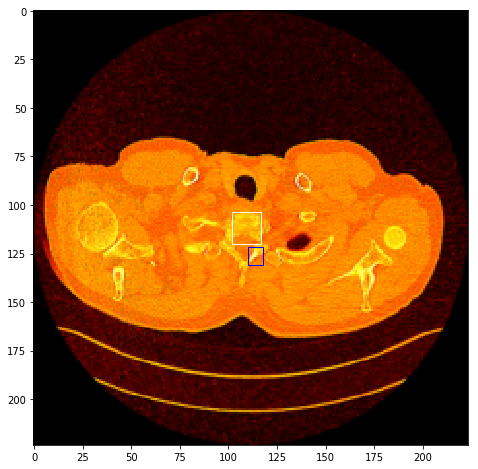

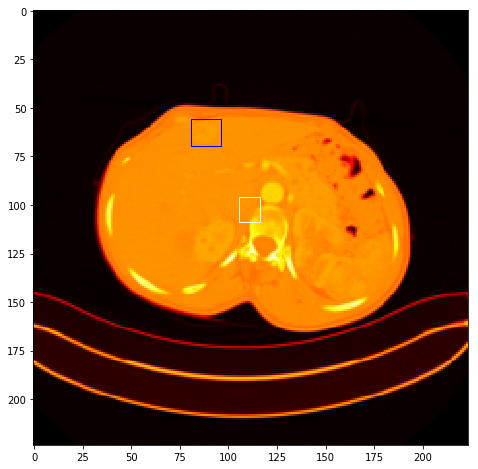

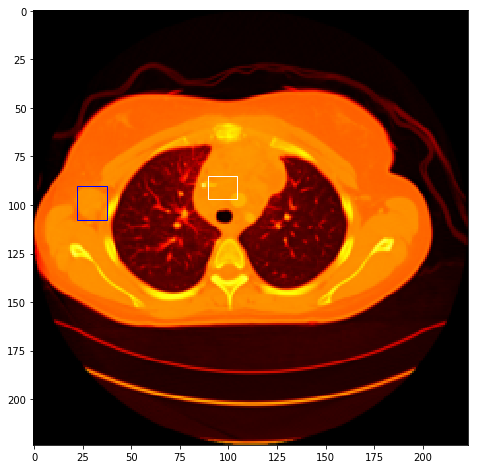

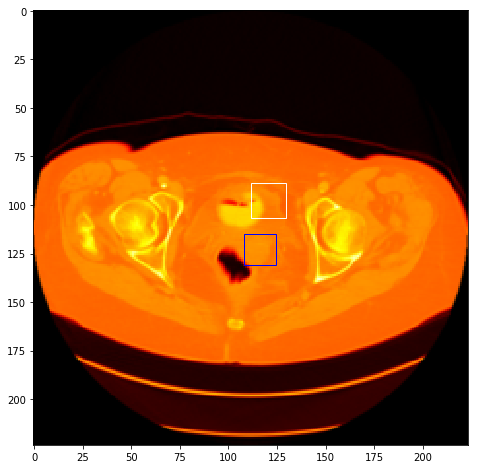

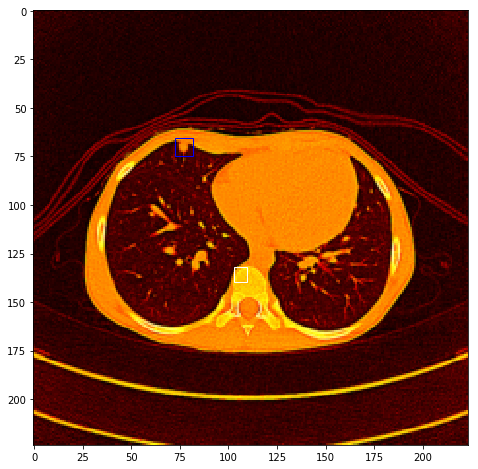

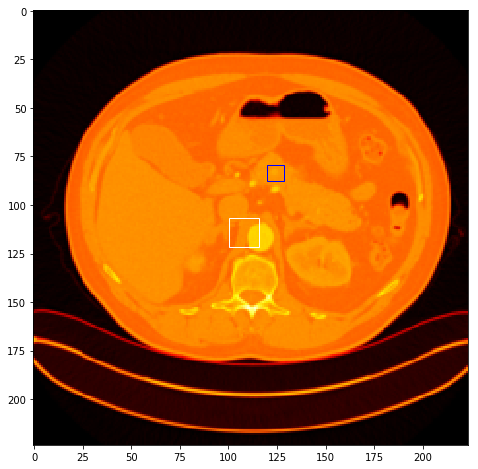

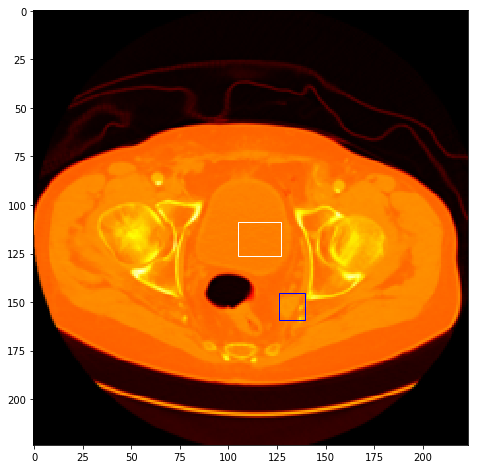

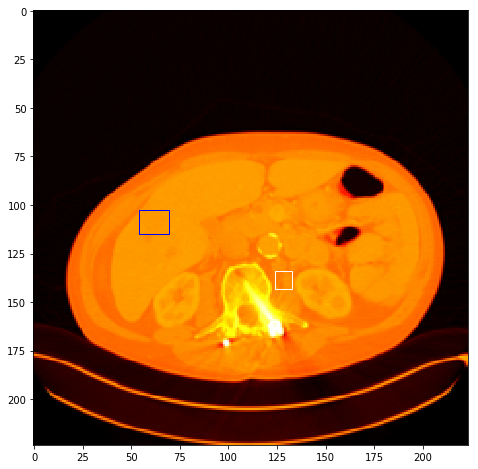

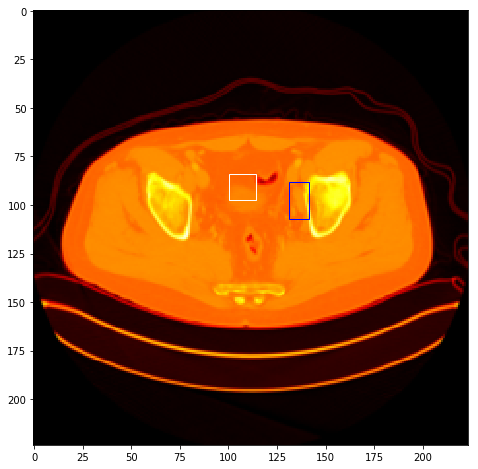

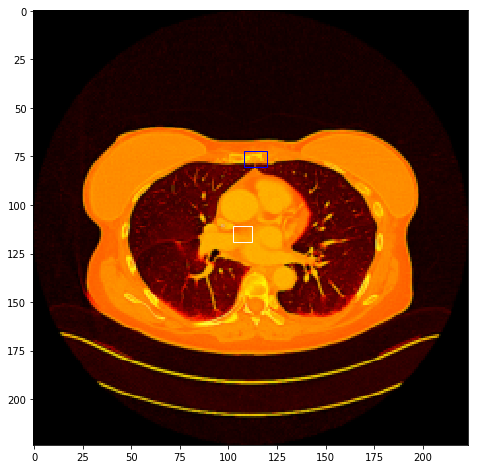

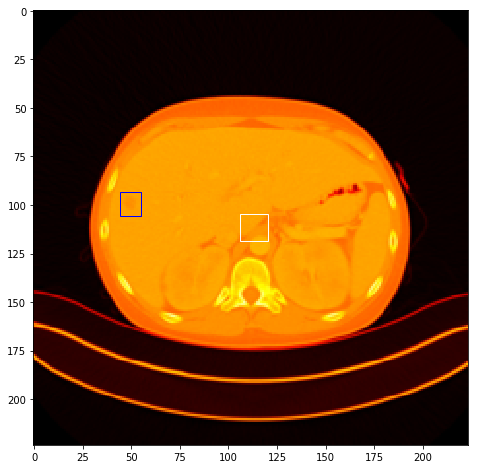

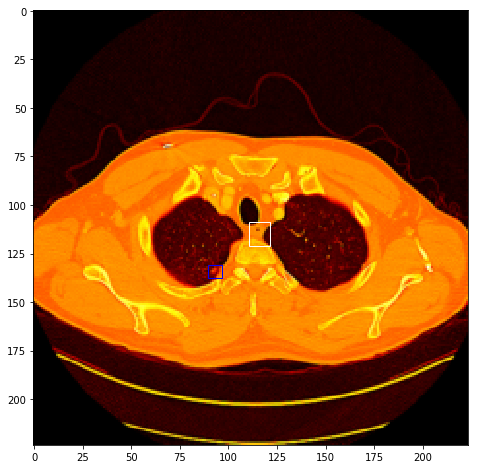

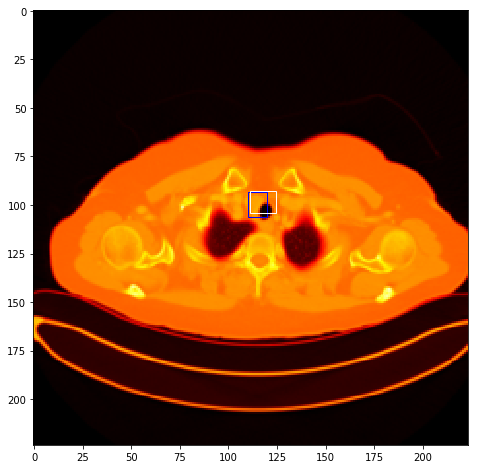

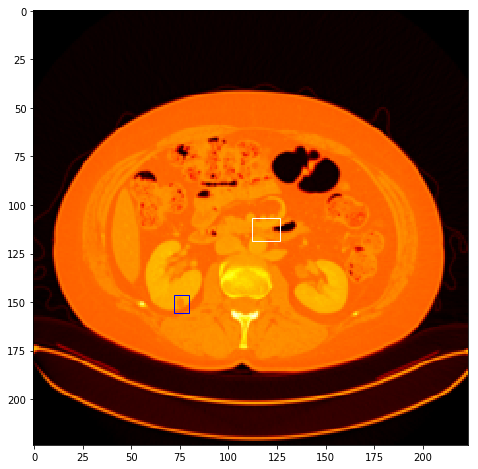

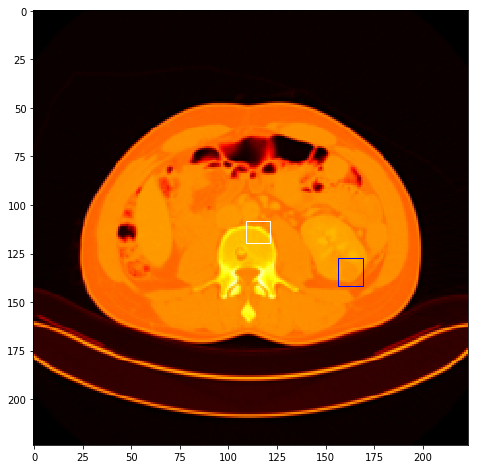

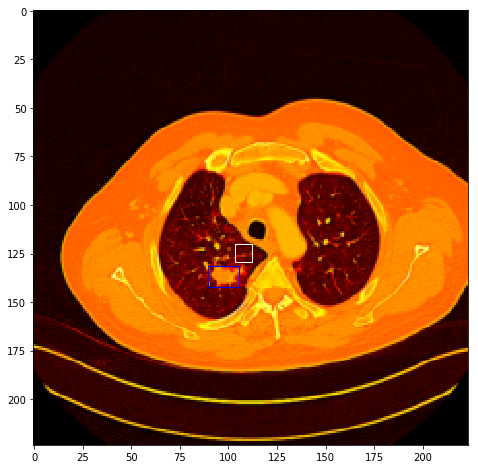

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9b897a0630>>
Traceback (most recent call last):
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/mark/miniconda3/en

In [28]:
visualize_model(model_ft, 16, typ='val')

In [19]:
def check_output(model, criterion):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels, bb) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            bb = bb.to(device)

            outputs = torch.sigmoid(model(inputs))

            loss = criterion(outputs.view(-1, 1), bb.view(-1, 1))
            print(outputs)
            print(bb)
            print('l', loss)
            print(loss.sum(dim=1))
#             print(loss.item())
            return outputs, bb
            break
    model.train(mode=was_training)

o, bb = check_output(model_ft, nn.PairwiseDistance())

tensor([[0.4412, 0.4864, 0.1349, 0.1328]], device='cuda:0')
tensor([[0.4592, 0.5501, 0.0566, 0.0790]], device='cuda:0')
l tensor([0.0180, 0.0637, 0.0783, 0.0538], device='cuda:0')


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9b8959f898>>
Traceback (most recent call last):
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/mark/miniconda3/en

RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
for f in model_ft.parameters():
    print(f)

In [13]:
models.vgg16(pretrained=False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d